# Draw a polygon on a map for a datacube query

Get landsat 8 images for a given polygon by drawing your area of interest on a map. 

Authorship: Ness Newey


In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

import plotly.plotly as py
from traitlets import link
import ipywidgets as widgets


In [2]:
center = [-12.543839666237682, 131.08474731445315]
zoom = 10


m = Map(center=center, zoom=zoom,layout=dict(width='400px', height='400px'))

#Let's draw a second map 

m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


# Now create the DrawControls and add it to the Maps using add_control. 
# We also register handlers for draw events. These will fire when a polygon is drawn created, edited or deleted 
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path, 
# along with its embedded style.

draw_control = DrawControl(polyline={})
draw_control2 = DrawControl(polygon={'shapeOptions': {'color': '#0000FF'}}, polyline={})
def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

    
def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)


#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)



#m2.clear_layers

In [3]:
#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

In [4]:
from ipywidgets import HBox
HBox([m,m2])

HBox(children=(Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-12.543839666237682, 131.08474731445315], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {}}),), default_tiles=TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']), layers=(TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(height='400px', width='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10), Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 'max_zoom': 20, 'attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', 'name': 'Esri.WorldImagery'}, center=[-12.543839666237682, 131.08474731445315], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {'color': '#0000FF'}}),), default_tiles=TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'), layers=(TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'),), layout=Layout(height='400px', width='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10)))

In [5]:
#now test if we can query using the poly to load data 
#TODO triple check projection

import datacube
from shapely.geometry import Polygon
from datacube.utils import geometry
dc=datacube.Datacube()

#Leaflet return geometry in EPSG:4326

geom_crs = geometry.CRS('EPSG:4326') 

geom=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)

start_of_epoch = '2015-01-01'
end_of_epoch =  '2015-12-31'


#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                         'green',
                         'red',
                         'nir',
                         'swir1',
                         'swir2'
                         ]

query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
    }

data= dc.load(product= 'ls8_nbart_albers', measurements=bands_of_interest,
                 group_by='solar_day', **query)



/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning:

'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 



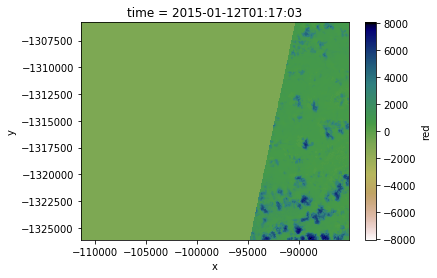

In [6]:
data.red.isel(time=1).plot(cmap='gist_earth_r')